In [40]:
%matplotlib inline
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split

import keras
import matplotlib.pyplot as plt
from rasterio.plot import show
import xarray as xr

import rasterio
import glob
import os
import numpy as np
import pandas as pd
import pandas_profiling as pp

In [41]:
data = pd.read_csv('./satellite_dataset.csv')
data.head()

,blue,green,red,nir,swir1,swir2,wofs,bosque,wofs_bosque,ninguno
0,203.0,131.0,36.0,21.0,61.0,46.0,1,0,0,0
1,207.0,137.0,39.0,27.0,71.0,59.0,1,0,0,0
2,393.0,325.0,217.0,200.0,254.0,176.0,1,0,0,0
3,269.0,201.0,58.0,11.0,51.0,43.0,1,0,0,0
4,194.0,218.0,112.0,103.0,153.0,130.0,1,0,0,0


In [6]:
pp.ProfileReport(data)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [42]:
dataset_X = data.drop(columns=['wofs','bosque','wofs_bosque','ninguno'], axis=1)
dataset_X.head()

,blue,green,red,nir,swir1,swir2
0,203.0,131.0,36.0,21.0,61.0,46.0
1,207.0,137.0,39.0,27.0,71.0,59.0
2,393.0,325.0,217.0,200.0,254.0,176.0
3,269.0,201.0,58.0,11.0,51.0,43.0
4,194.0,218.0,112.0,103.0,153.0,130.0


In [43]:
dataset_Y = data[['wofs','bosque','wofs_bosque','ninguno']]
dataset_Y.head()

,wofs,bosque,wofs_bosque,ninguno
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [44]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_Y, test_size=0.2)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [45]:
# DEFINICIÓN DEL MODELO
# Hay dos maneras de construir modelos en Keras: Secuencial y Funcional
# El modelo secuencial permite construir modelos capa por capa.
# El modelo funcional permite construir modelos mas complicados.

# La capa Flaten transforma los datos de un arreglo bidimensional de 28x28 a un arreglo 
# unidimensional de 784 posiciones(28x28) esto solo formatea el conjutno de datos

# La capa Dense significa que cada neurona en una capa esta conectada a todas las neuronas 
# localizadas en la capa anterior y con todas en la siguiente capa.

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(6,)),
    keras.layers.Dense(128,input_dim=6, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

# CONFIGURACIÓN DE PARÁMETROS
# La compilación del modelo comprende la configuración de parámetros 
# usados durante el entrenamiento: algori tmo de optimización, medida 
# de exactitud, etc.

# optimizer: Adam es un algoitmo de optimización. Además es un método de tasa de aprendizaje adaptativo, 
# loss: calcula la diferencia entre la salida y la variable objetivo. Mide la precisión del modelo durante 
# el entrenamiento y queremos minimizar esta función.
# metrics: Son las métricas que se desan calcular durante el entrenamiento. mide la fracción de imágenes que 
# están clasificadas correctamente.

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen de parámetros del modelo
model.summary()

# ENTRENAMIENTO
model.fit(X_train, y_train, epochs=15)

# EVALUACIÓN
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________

Epoch 1/15
800000/800000 [==============================] - 25s 31us/step - loss: 0.2763 - accuracy: 0.9734
Epoch 2/15
800000/800000 [==============================] - 25s 31us/step - loss: 0.0541 - accuracy: 0.9807
Epoch 3/15
800000/800000 [==============================] - 25s 31us/step - loss: 0.0531 - accuracy: 0.9818
Epoch 4/15
800000/800000 [==============================] - 25s 31us/step - loss: 0.0502 - accuracy: 0.9820
Epoch 5/15
800000/800000 [==============================] - 25s 31us/step - loss:

In [28]:
y_train

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [27]:
X_train

array([[ 161.,  387.,  223., 2997., 1338.,  479.],
       [ 211.,  173.,   29.,   -9.,   32.,   30.],
       [ 249.,  218.,   65.,   21.,   57.,   49.],
       ...,
       [ 204.,  166.,   74.,   64.,  110.,   90.],
       [ 330.,  251.,  138.,  111.,  129.,   98.],
       [ 165.,   86.,   -7.,  -15.,   37.,   31.]])

In [47]:
def predict_with_class(model,instance=[]):
    proba = model.predict([[ instance ]])
    index = np.argmax(proba)
    # classes = ['agua','bosque','agua_o_bosque','ninguno']
    classes = [1,2,3,4]
    return classes[index]

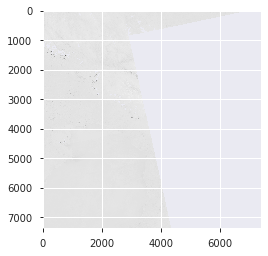

In [77]:
import rasterio
dataset = rasterio.open(path_tiff)
dataset.read

In [78]:
dataset.indexes

(1, 2, 3, 4, 5, 6)

In [86]:
band = xr.open_rasterio(path_tiff)
band

<xarray.DataArray (band: 6, y: 7373, x: 7408)>
[327715104 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6
  * y        (y) float64 8.0 8.0 8.001 8.001 8.001 8.001 8.002 8.002 8.002 ...
  * x        (x) float64 -72.0 -72.0 -72.0 -72.0 -72.0 -72.0 -72.0 -72.0 ...
Attributes:
    transform:   (0.0002699949999999998, 0.0, -72.00010664, 0.0, 0.0002713020...
    crs:         +init=epsg:4326
    res:         (0.0002699949999999998, -0.0002713020000000001)
    is_tiled:    0
    nodatavals:  (-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, -9999.0)

In [73]:
from affine import Affine
da = xr.open_rasterio(path_tiff)
transform = Affine.from_gdal(*da.attrs['transform'])
nx, ny = da.sizes['x'], da.sizes['y']
x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform

TypeError: from_gdal() takes 7 positional arguments but 10 were given

In [9]:
import gdal
path = '../data/prueba/mosaico.tif'
ds = gdal.Open(path)
metadata = ds.GetMetadata()
metadata.pop('AREA_OR_POINT',None)
metadata

{'Band_1': 'green',
 'Band_2': 'swir2',
 'Band_3': 'nir',
 'Band_4': 'blue',
 'Band_5': 'red',
 'Band_6': 'swir1'}

In [18]:
da = xr.open_rasterio(path)
da.y.values 

array([ 8.00001772,  8.00028903,  8.00056033, ...,  9.99951346,
        9.99978477, 10.00005607])

In [30]:
path = '../data/prueba/mosaico.tif'

def get_bands_positions(path):
    """
    Permite obtener las posiciones y los nombres de las bandas
    a partir de los metadatos de la imágen tif.
    
    [(1, 'green'), (2, 'swir2'), (3, 'nir'), (4, 'blue'), (5, 'red'), (6, 'swir1')]
    """
    ds = gdal.Open(path)
    # Extracción de los metadatos del tif
    metadata = ds.GetMetadata()
    # Extracción de la posición y nombre de las bandas
    positions = [ (int(k[-1]) - 1,v) for k,v in metadata.items() if 'Band_' in k ]
    
    return positions


def load_ideam_geotif(path):
    
    positions = get_bands_positions(path)
    
    data_array = xr.open_rasterio(path)

    # Define las coordenadas de los puntos
    coords = { 
        'x':data_array.x.values, 
        'y':data_array.y.values 
    }
    
    # Define el orden de las dimensiones
    dims = ('y','x')
    
    # Define los metadatos o atributos
    attrs = {
        'crs': darray.crs,
        'transform': darray.transform
    }
    
    data = {}
    for band_index, band_name in positions:
        data[band_name] = xr.DataArray(
            data=data_array.values[band_index], 
            coords=coords, 
            dims=dims, 
            name=band_name, 
            attrs=attrs
        )
    
    return data

tif = load_ideam_geotif(path)
tif

{'green': <xarray.DataArray 'green' (y: 7373, x: 7408)>
 array([[417.5, 518. , 410. , ...,   nan,   nan,   nan],
        [182.5, 299. , 429. , ...,   nan,   nan,   nan],
        [ 96. , 123.5, 265. , ...,   nan,   nan,   nan],
        ...,
        [518.5, 522. , 523.5, ...,   nan,   nan,   nan],
        [512.5, 518. , 524. , ...,   nan,   nan,   nan],
        [507. , 511. , 521.5, ...,   nan,   nan,   nan]], dtype=float32)
 Coordinates:
   * x        (x) float64 -72.0 -72.0 -72.0 -72.0 -72.0 -72.0 -72.0 -72.0 ...
   * y        (y) float64 8.0 8.0 8.001 8.001 8.001 8.001 8.002 8.002 8.002 ...
 Attributes:
     crs:        +init=epsg:4326
     transform:  (0.0002699949999999998, 0.0, -72.00010664, 0.0, 0.00027130200...,
 'swir2': <xarray.DataArray 'swir2' (y: 7373, x: 7408)>
 array([[ 925. , 1275. ,  950. , ...,    nan,    nan,    nan],
        [ 389.5,  717.5, 1142. , ...,    nan,    nan,    nan],
        [ 306.5,  342.5,  631. , ...,    nan,    nan,    nan],
        ...,
        [ 110.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


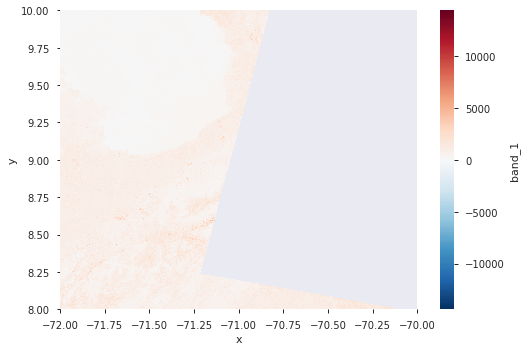

In [24]:
data.plot()

In [81]:
shape = tif['red'].shape
result = np.zeros(shape=shape)
shape

(7373, 7408)

In [59]:
max_data = 10000
# len(np.indices((7373, 7408))[0])
len(np.argwhere(~np.isnan(tif['blue'].values)))
data_points = random.sample(list(data_points), max_data)
# ~np.isnan(tif['blue'].values

27667864

In [80]:
max_data = 27667864
# len(np.indices((7373, 7408))[0])
data_points = np.argwhere(~np.isnan(tif['blue'].values))
# data_points
# data_points = random.sample(list(data_points), max_data)
data_points = list(data_points)[:max_data]

def process(i,j):
# for i,j in data_points:
    blue = tif['blue'].values[i,j]
    green = tif['green'].values[i,j]
    red = tif['red'].values[i,j]
    nir = tif['nir'].values[i,j]
    swir1 = tif['swir1'].values[i,j]
    swir2 = tif['swir2'].values[i,j]
    instance = [blue,green,red,nir,swir1,swir2]
#     result[i,j] = predict_with_class(model,instance)
    result[i,j] = 1


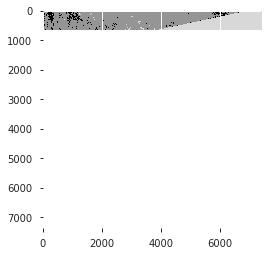

In [71]:
show(result)

In [ ]:
from joblib import Parallel, delayed

r = Parallel(n_jobs=8, require='sharedmem')(delayed(process)(i,j) for i,j in data_points)